Fitting the best linear predictor BLP for the JPTA data to test for heterogeneity.

First, we need models for the baseline functions that 

In [21]:
# imports
import pandas as pd
from econml.grf import CausalForest
from econml.grf import CausalIVForest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# loading the data
jtpa = pd.read_csv("jtpa_doubleclean.csv")
jtpa.head(3)

,recid,radate,assignmt,site,training,afdc,sex,class_tr,ojt_jsa,oth_serv,...,hsorged,black,hispanic,age2225,age2629,age3035,age3644,age4554,f2sms,wkless13
0,300001,05/16/89,1,NE,1,0,0,0,0,1,...,1.0,1,0,0,0,0,0,1,0,1.0
1,300002,08/30/89,1,LC,1,0,0,0,0,1,...,1.0,0,0,1,0,0,0,0,0,0.0
2,300006,08/18/88,1,HF,0,0,0,1,0,0,...,1.0,0,1,0,0,1,0,0,0,1.0


In [22]:
# split data into auxiliary and main sample, stratified by assignment
auxiliary_index, main_index = train_test_split(jtpa.index, stratify=jtpa['assignmt'], test_size=0.7, random_state=42)

auxiliary = jtpa.loc[auxiliary_index].reset_index()
main = jtpa.drop(auxiliary_index).reset_index()
print(len(auxiliary), len(main))

2922 6821


In [23]:
# how many in auxiliary are untreated to learn baseline?
auxiliary[auxiliary["assignmt"] == 0].shape

(968, 27)

In [24]:
# define X
features = ['afdc', 'sex', 'married', 'pbhous', 'hsorged', 'black', 'hispanic', 'wkless13','age', 'prevearn']

In [25]:
# fit random forest to learn E(Y|D=0, X)
X_aux = auxiliary[features + ["assignmt"] + ["training"]]
Y_aux = auxiliary["earnings"]

# get grid for regularization
grid = {"n_estimators": [10, 50, 100], "max_depth": [2, 5, 8], "min_samples_leaf": [4, 6, 10]}
rf = RandomForestRegressor()
gs = GridSearchCV(rf, grid, cv = 4, verbose=1)
gs.fit(X = X_aux[X_aux["assignmt"] == 0][features], y = Y_aux[X_aux["assignmt"] == 0])

# get the best model
b = gs.best_estimator_

Fitting 4 folds for each of 27 candidates, totalling 108 fits


In [26]:
b.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [27]:
# fit causal forest to learn E(Y(0) - Y(1)|X)

cf = CausalForest(min_samples_leaf=2)
cf.fit(X = X_aux[features], T = X_aux["assignmt"], y = Y_aux)

cf_iv = CausalIVForest(min_samples_leaf=2)
cf_iv.fit(X = X_aux[features], T = X_aux["training"], y = Y_aux, Z = X_aux["assignmt"])

CausalIVForest(min_samples_leaf=2)

In [28]:
# get predictions on main sample
b_preds = b.predict(main[features])
cf_preds = pd.Series(cf.predict_full(main[features])[:,0]) # extract from (n,1) array
cf_iv_preds = pd.Series(cf_iv.predict_full(main[features])[:,0]) # extract from (n,1) array


We can now fit the BLP for $s_0(X)$. This this outcome is unobserved, Chernozukov et al. suggests to use a certain weighted linear projection, where the weights are given by the inverse of the variance of the propensity score. Since in our random experiment, the propensity score is constant, i.e. $e(X) = p \: \forall X$, the weights are also constant and can be ignored.

In [29]:
# build Weighted Residual BLP to estimate coefficients of BLP
# Strategy A in Chernozhukov et al. (2018)

p = main.assignmt.mean()

# get dependent variables
finite_sample_improv = pd.DataFrame({"const" : 1, "bZ" : b_preds})
intercept = pd.Series(main.assignmt - p, name = "intercept")
slope = pd.Series((main.assignmt - p)*(cf_preds - cf_preds.mean()), name = "slope")

# collect all dependent variables
dependent_vars = pd.concat([finite_sample_improv, intercept, slope], axis = 1)

In [30]:
dependent_vars.sample(6)

,const,bZ,intercept,slope
2455,1,16242.706320,0.331183,949.902382
5096,1,12353.832826,0.331183,1833.196039
3969,1,15123.994434,0.331183,-1102.601729
4242,1,33027.609104,0.331183,595.021769
4524,1,32479.496156,0.331183,-1190.323164
4025,1,11726.008150,0.331183,279.927871


In [31]:
# run linear model
model = sm.OLS(main.earnings, dependent_vars)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnings   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     311.9
Date:                Thu, 02 May 2024   Prob (F-statistic):          9.69e-190
Time:                        19:19:27   Log-Likelihood:                -75625.
No. Observations:                6821   AIC:                         1.513e+05
Df Residuals:                    6817   BIC:                         1.513e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2246.8528    495.545      4.534      0.000    1275.429    3218.276
bZ             0.9125      0.030     30.410      0.000       0.854       0.971
intercept   1379.3003    406.740      3.391      0.001     581.963    2176.637
slope         -0.0646      0.141     -0.458      0.647      -0.341       0.212
==============================================================================
Omnibus:                     1669.348   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4384.695
Skew:                           1.315   Prob(JB):                         0.00
Kurtosis:                       5.917   Cond. No.                     4.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is clearly not significant, which is surprising...


Retrying with another random forest

In [12]:
# also using a standard RF to predict E(Y|D=1, X)

# fit random forest to learn E(Y|D=1, X) using parameters from b

# fit random forest to learn E(Y|D=0, X)
# get grid for regularization
rf2 = RandomForestRegressor(**b.get_params())
rf2.fit(X = X_aux[X_aux["assignmt"] == 1][features], y = Y_aux[X_aux["assignmt"] == 1])

# get alternative cate_pred
b_preds2 = rf2.predict(main[features])
cate_pred = pd.Series(b_preds2 - b_preds)

In [13]:
# replace slope with cate_pred
dependent_vars["slope"] = cate_pred

In [14]:
# rename and re run
dependent_vars.rename({"bZ": "B(x)", "intercept": "\alpha", "slope": "[S(x)-ES(x)]"}, inplace = True, axis = 1)

# re run linear model
model = sm.OLS(main.earnings, dependent_vars)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnings   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     374.9
Date:                Thu, 02 May 2024   Prob (F-statistic):          2.21e-225
Time:                        19:13:00   Log-Likelihood:                -75542.
No. Observations:                6821   AIC:                         1.511e+05
Df Residuals:                    6817   BIC:                         1.511e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.4511    521.978      0.055      0.957    -994.788    1051.690
B(x)             1.0239      0.031     33.321      0.000       0.964       1.084
lpha         1480.3458    401.934      3.683      0.000     692.429    2268.263
[S(x)-ES(x)]     0.6041      0.044     13.620      0.000       0.517       0.691
==============================================================================
Omnibus:                     1653.518   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4413.340
Skew:                           1.296   Prob(JB):                         0.00
Kurtosis:                       5.968   Cond. No.                     4.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
latex_BLP = results.summary().tables[1].as_latex_tabular()

In [16]:
print(latex_BLP)

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                      & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}        &      28.4511  &      521.978     &     0.055  &         0.957        &     -994.788    &     1051.690     \\
\textbf{B(x)}         &       1.0239  &        0.031     &    33.321  &         0.000        &        0.964    &        1.084     \\
\textbf{lpha}        &    1480.3458  &      401.934     &     3.683  &         0.000        &      692.429    &     2268.263     \\
\textbf{[S(x)-ES(x)]} &       0.6041  &        0.044     &    13.620  &         0.000        &        0.517    &        0.691     \\
\bottomrule
\end{tabular}
\end{center}


In [33]:
# compare BLP CATE to the CATE from causal forest on main sample

cf_df = pd.read_csv("final_df.csv")


In [34]:
cf_df = cf_df.loc[main_index,["CATE_cf", "CATE_cf_lb", "CATE_cf_ub"]]

In [35]:
cf_df["BLP"] = cate_pred

In [44]:
cf_df["cf_pred"] = cf_preds
cf_df["cf_iv_pred"] = cf_iv_preds

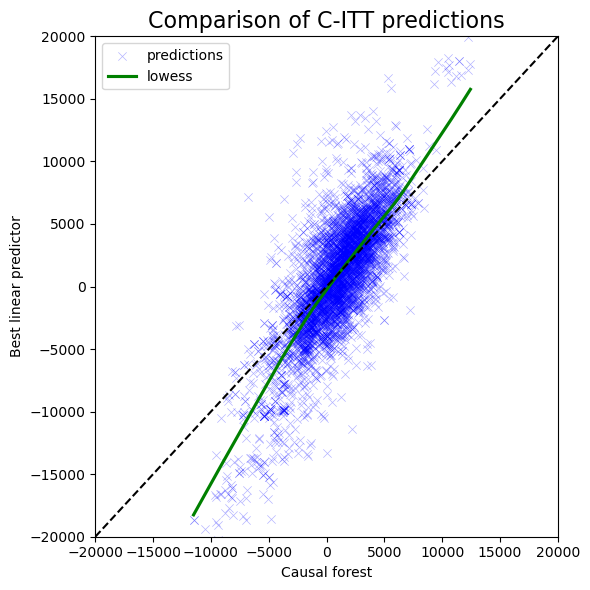

In [60]:
# scatterplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (6,6))
sns.scatterplot(x = "cf_pred", y = "BLP", data = cf_df, marker = "x", alpha = 0.3, color = "blue", label = "predictions")
# add line of best fit
sns.regplot(x = "cf_pred", y = "BLP", data = cf_df, scatter = False, lowess = True, color = "green", label = "lowess")
# add 45 degree line
plt.plot([-20000, 20000], [-20000, 20000], color = "black", linestyle = "--")
# set common axis limits
plt.xlim(-20000, 20000)
plt.ylim(-20000, 20000)
plt.xlabel("Causal forest")
plt.ylabel("Best linear predictor")
plt.title("Comparison of C-ITT predictions", fontsize = 16)
plt.legend()
plt.tight_layout()

# save fig
plt.savefig("BLP_vs_CF.pdf", format = "pdf", dpi = 400)

plt.show()

The CATE estimates from the BLP aren't very good.